In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv('cleaned_BTech_Survey.csv')
print("Dataset loaded successfully!")
print("\nShape of the dataset:", df.shape)
print("\nColumns in the dataset:")
print(df.columns.tolist())


Dataset loaded successfully!

Shape of the dataset: (92, 18)

Columns in the dataset:
['Timestamp', 'Full Name', 'Email ID', 'Mobile Number', 'Gender', 'Branch', 'Year of Study', 'Current CGPA (out of 10)', 'Average Study Hours per Week', 'Class Attendance (%)', 'Have you done any internships?', 'Number of Technical Clubs or Competitions Participated In', 'Number of Certifications or Online Courses Completed', 'Preferred Career choice', 'Resources Used for Learning (e.g., YouTube, Coursera, Books)', 'Main Challenges Faced During Study', 'Satisfaction with College Support Services (1 to 5) (Linear scale: 1 - Very Unsatisfied to 5 - Very Satisfied)', 'Any Suggestions to Improve Academic or Career Support']


In [8]:
# Select features for prediction
features = [
    'Year of Study',
    'Average Study Hours per Week',
    'Number of Technical Clubs or Competitions Participated In',
    'Have you done any internships?',
    'Branch'
]

# Target variable
target = 'Current CGPA (out of 10)'

# Create X (features) and y (target)
X = df[features].copy()
y = df[target]

# Encode categorical variables
le = LabelEncoder()
X['Have you done any internships?'] = le.fit_transform(X['Have you done any internships?'])
X['Branch'] = le.fit_transform(X['Branch'])
X['Year of Study'] = X['Year of Study'].str.replace('Nd', '').str.replace('Rd', '').str.replace('Th', '').str.replace('St', '').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")
print("\nFeatures used for prediction:", features)
print("\nShape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)


Data preprocessing completed!

Features used for prediction: ['Year of Study', 'Average Study Hours per Week', 'Number of Technical Clubs or Competitions Participated In', 'Have you done any internships?', 'Branch']

Shape of training data: (73, 5)
Shape of testing data: (19, 5)


Model Performance Metrics:
------------------------------
Mean Squared Error: 0.5236
Root Mean Squared Error: 0.7236
R-squared Score: -0.3400


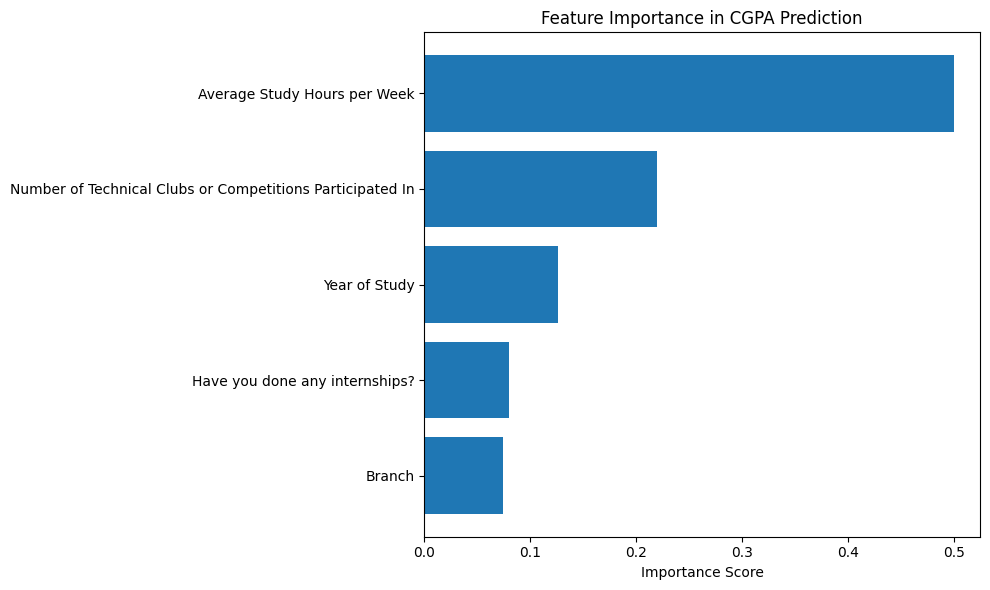

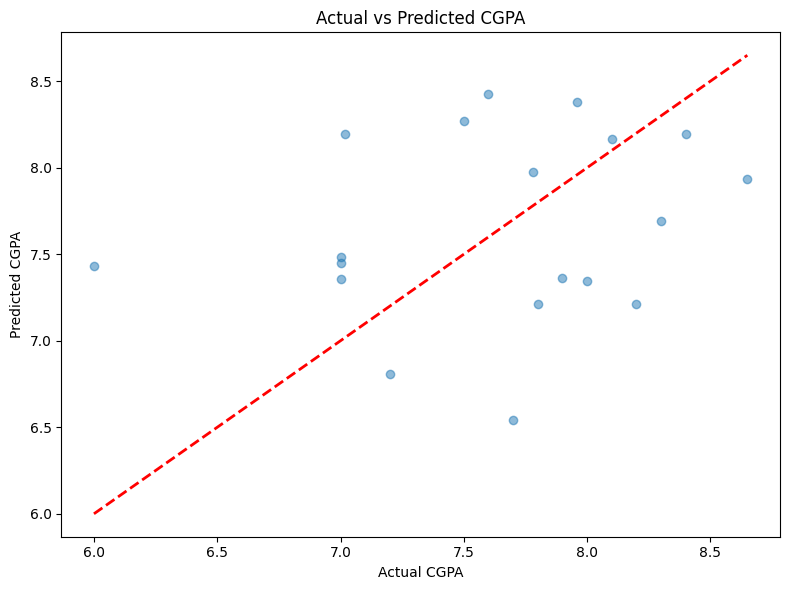

In [9]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print("-" * 30)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance plot
plt.figure(figsize=(10, 6))
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
importance = importance.sort_values('Importance', ascending=True)

plt.barh(importance['Feature'], importance['Importance'])
plt.title('Feature Importance in CGPA Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CGPA')
plt.ylabel('Predicted CGPA')
plt.title('Actual vs Predicted CGPA')
plt.tight_layout()
plt.show()


In [11]:
# Create and fit label encoders for categorical variables
internship_encoder = LabelEncoder()
branch_encoder = LabelEncoder()

# Fit the encoders on the original data
internship_encoder.fit(df['Have you done any internships?'])
branch_encoder.fit(df['Branch'])

def predict_cgpa(year, study_hours, clubs, internship, branch):
    """
    Predict CGPA for a new student
    
    Parameters:
    - year: int (1-4)
    - study_hours: float (average hours per week)
    - clubs: int (number of clubs/competitions)
    - internship: str ('Yes' or 'No')
    - branch: str (one of the branches in the dataset)
    """
    try:
        # Create a dataframe with the input values
        new_student = pd.DataFrame({
            'Year of Study': [year],
            'Average Study Hours per Week': [float(study_hours)],
            'Number of Technical Clubs or Competitions Participated In': [int(clubs)],
            'Have you done any internships?': [str(internship)],
            'Branch': [str(branch)]
        })
        
        # Encode categorical variables
        new_student['Have you done any internships?'] = internship_encoder.transform(new_student['Have you done any internships?'])
        new_student['Branch'] = branch_encoder.transform(new_student['Branch'])
        new_student['Year of Study'] = int(year)
        
        # Scale the features
        new_student_scaled = scaler.transform(new_student)
        
        # Make prediction
        predicted_cgpa = rf_model.predict(new_student_scaled)[0]
        return predicted_cgpa
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        print("\nPlease ensure:")
        print("- Year is between 1-4")
        print("- Internship is 'Yes' or 'No'")
        print(f"- Branch is one of: {', '.join(df['Branch'].unique())}")
        return None

# Example predictions
example_students = [
    {
        'year': 2,
        'study_hours': 15,
        'clubs': 2,
        'internship': 'No',
        'branch': 'Computer Science'
    },
    {
        'year': 3,
        'study_hours': 20,
        'clubs': 3,
        'internship': 'Yes',
        'branch': 'Electronics'
    }
]

print("Example Predictions:")
print("-" * 50)
for i, student in enumerate(example_students, 1):
    print(f"\nStudent {i}:")
    print("-" * 20)
    for key, value in student.items():
        print(f"{key.title()}: {value}")
    
    predicted_cgpa = predict_cgpa(
        student['year'],
        student['study_hours'],
        student['clubs'],
        student['internship'],
        student['branch']
    )
    
    if predicted_cgpa is not None:
        print(f"\nPredicted CGPA: {predicted_cgpa:.2f}")
    print("-" * 20)


Example Predictions:
--------------------------------------------------

Student 1:
--------------------
Year: 2
Study_Hours: 15
Clubs: 2
Internship: No
Branch: Computer Science

Predicted CGPA: 7.69
--------------------

Student 2:
--------------------
Year: 3
Study_Hours: 20
Clubs: 3
Internship: Yes
Branch: Electronics

Predicted CGPA: 7.21
--------------------
